<a href="https://colab.research.google.com/github/dmitr2ish/MOMO_2023/blob/main/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_Plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import pandas as pd # Библиотека Pandas для работы с табличными данными

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

Этого нам будет достаточно чтобы написать алгоритм линейной регрессии "своими руками"

если **не** хотите рисунки на темном фоне **не** выполняйте следующую ячейку

In [ ]:
plt.style.use('dark_background')

[полный перечень стилей Matplotlib](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)

# Генерация Данных

Создание одномерных данных, которые могут быть функциями некоторыми функциями от входных данных `X`.

В учебных целях (чтобы не иметь всегда `100%` точности) мы также добавим  шумы к данным.

Т.о. есть мы будем иметь как истинный вариант зависимости, так и зашумленный.

Созданные данные могут быть как линейными, `f= None`, так и  гармоническими (`np.sin, np.cos`) или экспонециальными `np.exp` (или можно задать свои функции)

In [ ]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    """Генерация произвольной зависимости
    Входные переменные:
    ===========
    x: массив данных из которых будет генерироваться зависимость
    a: коэффициент на который входные данные будут умножаться
    если а - список, то это коэффициенты в полиномиальной зависимости
    так, а = [1,2,3] позволит сгенерировать зависимость вида 1*x+ 2*x^2 +3*x^3
    b: коэффициент который будет добавлен к данным (постоянная прибавочка)
    f: функция которая будет применена к зависимости. Можно задать списком. Тогда это будут разные колонки
    """
    x = np.atleast_1d(x)[:] # убеждаемся что данные - одномерный массив
    a = np.atleast_1d(a)

    if f is None: f = lambda x:x # если функция не задана (None) то ничего не происходит
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0) # домнажаем входные данные на коэффициенты (и если надо возводим в степень)

    return f(x+ b)

def noises(shape , noise_power):
    """Генерация случайного шума
    Входные переменные:
    ===========
    shape: размерность массива данных
    noise_power: коэффициент ~ сила шума
    """
    return np.random.randn(*shape) *noise_power # библиотека numpy может генерировать случайные числа.
                                                # в данном случае - нормальное распределение (среднее = 0, стандартное отклонение = 1 )

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    """Генерация набора данных
    Входные переменные:
    ===========
    a: коэффициент на который входные данные будут умножаться
    если а - список, то это коэффициенты в полиномиальной зависимости
    так, а = [1,2,3] позволит сгенерировать зависимость вида 1*x+ 2*x^2 +3*x^3
    b: коэффициент который будет добавлен к данным (постоянная прибавочка)
    f: функция которая будет применена к зависимости. Можно задать списком. Тогда это будут разные колонки
    N: количество точек данных
    x_max: максимальное значение данных
    noise_power: коэффициент ~ сила шума
    random_x: как будут распределены данные (линейно, или случайно)
    seed: фиксированный сид случайных чисел (для повторяемости)
    """

    np.random.seed(seed) # фиксируем случайный seed

    if random_x:# если мы хотим случайно распределить данные
        x = np.sort(np.random.rand(N))*x_max # то x будет N случайных числе из диапазона от 0 до x_max
    else: # иначе
        x = np.linspace(0,x_max,N) # х это равномерно распределенные N чисел из диапазона от 0 до x_max

    y_true = np.array([]) # создаем пустой массив который будет "наполнять" зависимостями

    for f_ in np.append([], f): # если f - задана списком, то мы учтем все варианты
        y_true=np.append(y_true, true_fun(x, a, b, f_)) # применяем описанную выше функцию true_fun

    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power) # добавляем шум

    return y, y_true, np.atleast_2d(x).T # возвращаем зашумленные значения зависимостей, зависимости без шума, и массив входных данных



Попробуем визуализировать получившиеся данные

In [ ]:
def vis_data(y, y_true,x, title):
    """Визуализация полученного набора данных
    Входные переменные:
    ===========
    y: зашумленные значения зависимостей
    y_true: зависимости без шума
    x: массив входных данных
    title: общий заголовок
    """
    fig  = plt.figure(figsize=(14,8))# создаем "полотно", на котором будем "рисовать" график
    # рисуем с помощью библиотеки matplotlib
    plt.scatter(x[:,0], # какую переменную используем для горизонтальной оси - массив данных х
                y, # какую переменную используем для вертикальной оси - зашумленные значения зависимостей
                edgecolor='b', #  цвет маркера
                label="Зашумленные данные", # название зависимости, которое будет отображено в легенде
                s=196, # квадрат радиуса
                alpha = 0.6) # прозрачность
    plt.scatter(x[:,0], y_true,label="Реальные данные", s=81,c='g', alpha = 0.8) # аналогично вышеописанному, только для зависимости без шума
                                                                                # и с другими параметрами маркеров (цвет, размер, прозрачность, название)
    plt.grid() # чтобы была сетка
    plt.xlabel('x',fontsize=35) # название горизонтальной оси
    plt.ylabel('y',fontsize=35) # название вертикальной оси
    plt.legend(fontsize=25) # чтобы была легенда
    plt.title(title, fontsize=25 ) # заголовок
    plt.xticks(fontsize = 25) # чтобы промежуточные значения горизонтальной оси были не маленькими
    plt.yticks(fontsize = 25);# чтобы промежуточные значения вертикальной оси были не маленькими
    plt.tight_layout() # чтобы полотно было без пустого пространство


In [ ]:
def vis_data_plotly(y, y_true,x, title):
    """Визуализация полученного набора данных с помощью библиотеки plotly
    Входные переменные:
    ===========
    y: зашумленные значения зависимостей
    y_true: зависимости без шума
    x: массив входных данных
    title: общий заголовок
    """
    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y_true[:,0],
        mode='lines+markers',
        name='Реальные данные',
        marker=dict(size = 10,
                    color='Green')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y[:,0],
        mode='markers',
        name='Зашумленные данные',
        opacity=0.5,
        marker=dict(size = 15,
                    color='LightSkyBlue',
                    line=dict(
                        color='Blue',
                        width=3
            )),

        )
    )
    fig.update_layout(
            title=title,
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()


**Линейная зависимость**

Приминяем описанные выше функции для генерации линейной зависимости вида

`y = 2*x+2`, где `х` изменяется в диапазоне от `0` до `1`, в `х` - `100` точек, "мощность" шума `0.1`

для этого запускаем функцию `dataset` с нужными параметрами

*   `a = 2` (на это число умножится `х`)
*  ` b = 2 `(это число добавится к `a*х`)
*   `f = None` (чтобы не было никаких других зависимостей)
*   `N = 100` (число точек)
*   `x_max =1` (максимальное значение `х`)
*   `noise_power = 0.1` (мощность шума)
*   `seed = 42` (фиксированный сид случайных чисел)
                       

а потом визуализируем данные с помощью функции `vis_data`



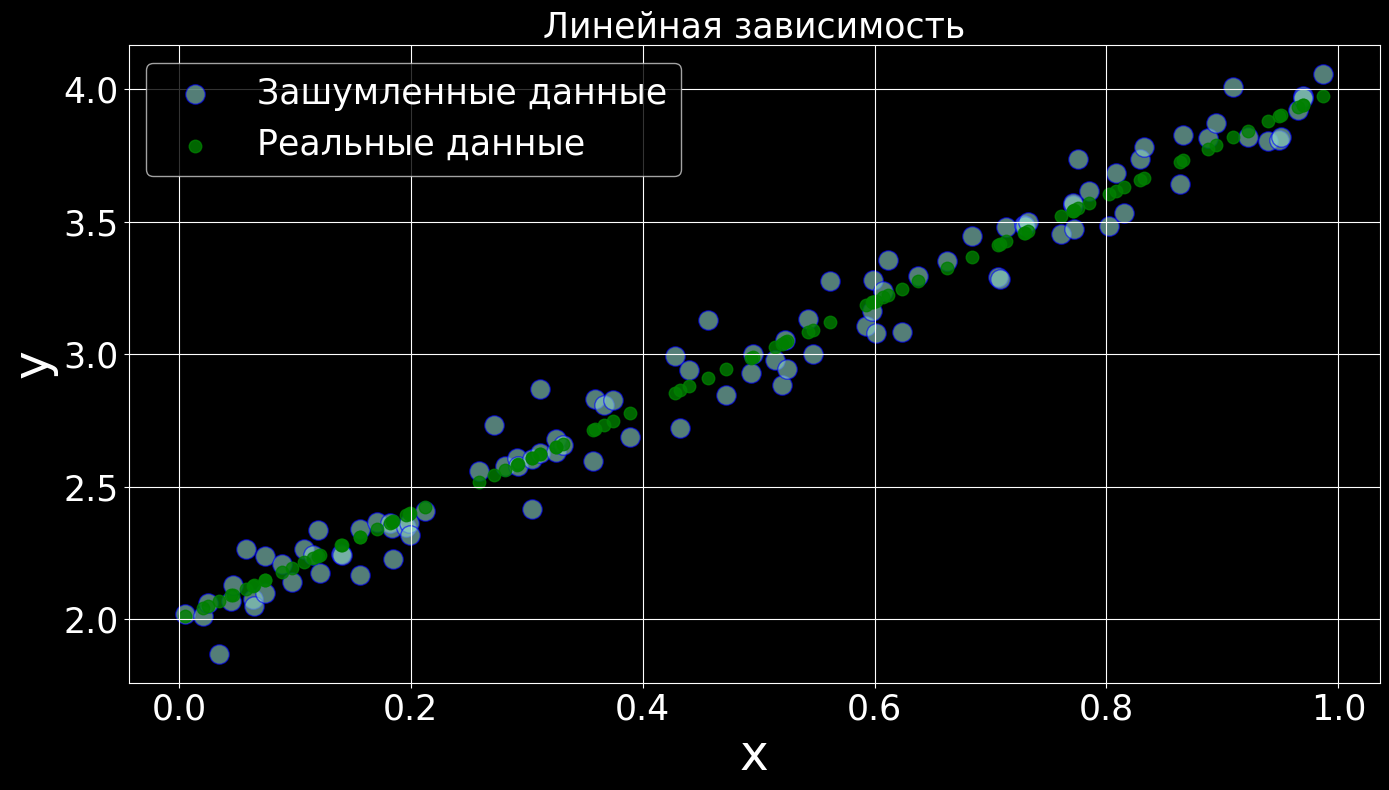

In [ ]:
y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 100,
                       x_max =1,
                       noise_power = 0.1,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')



Интерактивный вариант визуализации

In [ ]:
vis_data_plotly(y, y_true,x, 'Линейная зависимость')

### Мини-задание

1. Протестируйте генерацию данных с другими значениями параметров функций
* используйте другие названия переменных для получившихся данных (не `x`, `y`, `y_true`, а например `x1`, `y1`, `y1_true`)
* В частности попробуйте подставить в качестве параметра `f` разные функции (подойдут математические функции numpy такие как `np.cos`, `np.sin`, `np.exp`)

2. Выполните Визуализацию понравившим вам способом

# Линейная регрессия своими руками

## Немного теории

Проведем линейную регрессию. То есть оценим коэффициенты аппроксимации зашумленных данных функцией вида
$$ \hat{y}_i = \hat{a}x + \hat{b},$$
где $\hat{y}_i$ - это наши оценки значений $y_i$; $\hat{a}$ и $\hat{b}$ - оценинные коэффициенты модели.

В самом простом случае ( для нашего набора данных) мы могли бы найти коэффициенты $\hat{a}$ и $\hat{b}$ аналитически. Если бы не было шумов (была бы чистая линия), коэффициенты можно найти классическим решением линейной системы из 2 независимых уравнений. В случае шумов 2 уравнений может быть недостаточно. Оценки коэффициентов по каждым двум уравнениям могут различаться. Поэтому желательно иметь переопределенную систему (когда число уравнений больше числа переменных). Такую систему можно решать по-разному. Известно (теорема Гаусса-Маркова), что если шум в системе имеет нормальное распределение, то оптимальным будет решение методом наименьших квадратов. Для поиска такого решения предположим, что мы производим такие оценки коэффициентов $\hat{a}$ и $\hat{b}$, которые дают результат $\hat{y}$ c ошибкой $e$. Ошибку определим как $e_i = y_i- \hat{y}_i$. Теперь наша задача минимизация ошибки $\hat{y}$ для каждого значения $x$. В случае метода наименьших квадратов задача сводиться к минимизации одного значения среднего квадратов ошибки.  <br> Для линейной регрессии такую задачу можно решить аналитически. Однако как можно будет увидеть ниже такое решение не всегда рационально.

В более общем случае, допустим, что мы не знаем как лучше всего аппроксимировать зависимость, какую функцию использовать. Такая ситуация характерна для зависимостей, более сложных чем линейная. В таких случаях можно предположить, что выше указанной модели недостаточно. В более общем случае можно ввести модель целевой переменной как
 $$ \begin{align*}
   &y_i = \sum_{j=0}^{m}x_{ij}w_j +\epsilon_i \\
   \text{или так }& y_i = 1\cdot w_0 + x_{i1}\cdot w_1 + x_{i2}\cdot w_2 + x_{i3}\cdot w_3 + x_{i4m}\cdot w_4 + \epsilon_i \\
   \text{или так }& y_i = X_i W^T + \epsilon_i ,
   \end{align*}
   $$
где
<ul>
    <li> $y_i$ - целевой показаль предсказания для $i$ записи в наборе данных;</li>
    <li> $X_i  = \{x_{ij}\}_{j=1}^{m}$ - набор входных параметров для $i$ результата ;</li>
    <li> $W = \{w_{j}\}_{j=1}^{m}$ - набор весовых параметров, которые мы должны подобрать в моделе;</li>
    <li> $\epsilon_i$ - некоторый набор случайных (не объясняемых нашей моделью, остаточных) значений, мы будем считать их случайных шумом.</li>     

Данная модель соответствует как линейной регресии одной или нескольких переменных, так и полиномиальной или любой другой, где состовляющие ($x_{ij}$) можно считать независимыми составляющими.      
В качестве примера регрессионная модель одной переменных будет иметь вид
         \begin{align*}
   &\hat{y}_i = \sum_{j=0}^{1}x_{ij}w_j  \\
   \text{или так }& \hat{y}_i = 1\cdot w_0 + x_{i1}\cdot w_1  \\
   \text{или так }& \hat{y}_i = X_i W^T,
   \end{align*}
   
где <ul>
    <li> $\hat{y}_i $ - результат предсказания для $i$ записи в наборе данных.   </ul>   
        
Теперь рассмотрим решение для обозначенной модели одной переменной.

Введем функцию потрерь регрессии `loss_func` как квадрат разности между целевыми значениями и их предсказаниями
$$ L(\hat{y}_i,y_i)=L_i= (\hat{y}_i-y_i)^2 = \left(\sum_{j=0}^{2}x_{ij}w_j-y_i\right)^2 = \left(X_i W^T-y_i\right)^2 , $$
где  $L_i$ - функция потерь для результата (предсказания) с номером $i$. <br>
Также введем функцию расчета (предсказания) значений `forward`.

Отметим, что для нашего случая одной переменной (в выше приведенных обозначения) решение могло бы быть найдено как
$$L = \sum_{i=0}^{N-1}(y_i - \hat{y_i})^2 = \sum_{i=0}^{N-1}(y_i - (a\cdot x_i+b))^2 \to 0$$
тогда минимум $L$  будет соответствовать нулям ее производных по `a` и `b`:
$$ \begin{cases}
\frac{\partial{L}}{\partial{a}} = 2\sum_{i=0}^{N-1}(y_i - (a\cdot x_i+b))x_i = 0 \\
\frac{\partial{L}}{\partial{b}} = 2\sum_{i=0}^{N-1}(y_i - (a\cdot x_i+b)) = 0
\end{cases}
$$
Отсюда решение системы уравнений выглядит как
$$
\begin{cases}
a = \frac{N\sum xy - \sum x \sum y}{N\sum {x^2} -( \sum x)^2} \\
b = \frac{\sum y - a \sum x}{N}
\end{cases}
$$
В более общем случае мы могли бы записать уравнение как
$$ L =  \sum_{i=0}^{N-1}(y_i - W^TX_i)^2 =0 \text{ или } (y - W^TX)^2 =0$$
тогда
$$\frac{\partial{L}}{\partial{W}} = 2(y - W^TX)X = 0$$
или
$$W=(X^T X)^{-1} X^T y=X^+ y$$
Однако, если массивы $X$ и $y$ достаточно большие, то такое решение оказывается весьма вычислительно сложным. Для больших массивов данных чаще используют численные методы оптимизации. Среди таких методов наиболее зарекомендовал себя метод градиентного спуска.

Метод градиентного спуска  позволяет итерционно решить задачу оптимизации. В дискурсе данного курса мы будем называть такой процесс оптимизации `обучение`. Каждую итерацию принято называть `эпоха`. Ниже будет показ принцип обучения методом градиентного спуска и его реализация.

Важно отметить, что особенносью итеративных методов обучения является потенциальная ситуация переобучения/недообучения в ходе оптимизации. Проще всего это представить как ситуацию в которой мы ошибемся в выбранных значениях коэффициентов. Такое явление может происходить если, например, наша модель будет воспренимать все шумы, помехи и искажения входных данных как важные для точного ответа. Другими словами для данных, участвующих  в обучении (`обучающая выборка`) наша ошибка будет стремится к нулю. Однако, для данных, отличных от обучающей выборке точность будет не высокой. Чтобы недопустить этого на каждом шаге обучения мы будем проверять полученные коэффициенты модели. Для такой проверки мы будем использовать т.н. `валидационную` выборку. Как правило валидационная и тренировочная выборки выбирается из одних и тех же данных. В некоторых случаях, кроме данных выборок также может быть и третия выборка, независимая от двух указанных. Такая выборка будет необходима для проверки итоговой точности модели. Выборку можно назвать `тестовая выборка`. По существу, тестова выборка характеризует т.н. `обобщающую способность` то есть разность между точностью на тренировочных данных и данных в которых модель должна работать. Разность значенй точности должна быть как можно меньше.

## Тренировочная и тестовая выборка

Для того, чтобы выделить из входных данных тренировочную и тестовую выборку запишем следующую функцию. Функция будет иметь входные аргументы:
* `x,y` - входные данные и метки;
* `train_size` - размер тренировочной части;
* `test_size`  - размер тестовой части;
* `random_state` - состояние генератора случайных чисел;
* `shuffle` - необходимость перемешивания данных.

In [ ]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    """Разбиение данных на тренировочную-валидационную-тестовую
    Входные переменные:
    ===========
    x: матрица признаков
    y: вектор целевых меток
    train_size: размер тренировочной выборки (в долях или в штуках)
    test_size: размер тестовой выборки (в долях или в штуках)
    random_state: фиксированный сид случайных чисел (для повторяемости)
    shuffle: перемешиваем ли мы выборку или нет
    """
    if random_state: np.random.seed(random_state) # фиксируем случайный seed

    size = y.shape[0] # считаем сколько у нас точек
    idxs = np.arange(size) # массив индексов от 0 до количества точек
    if shuffle: np.random.shuffle(idxs) # если перемешиваем - то перемешиваем

    # если задаем test_size, но не задаем train_size
    if test_size and train_size is None:
        # тогда нам надо посчитать train_size
        # если размер задали в долях
        if (test_size<= 1):  train_size = 1 - test_size
        # если размер задали в штуках
        else:  train_size = size - test_size
        test_size = None    # обнулим переменную, чтобы потом не сломалось


    # если задаем train_size, но не задаем test_size, или мы некорректно задали размер  train_size
    if train_size is None or train_size > size: train_size = size

    # если задаем train_size
    if (train_size<= 1): train_size *= size

    # если test_size не обнулилось
    if test_size is not None:
        # если размер задали в долях
        if test_size<= 1: test_size *= size
        # если размер задали в штуках
        if test_size>size: test_size = size-train_size
    else: test_size = 0 # если обнулилось - то обнулилось)

    # разбиваем выборку на тренировочную и валидационную.
    # в тренировочную берем индексы от 0 до train_size
    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    # в валидационную берем индексы от train_size до size - test_size
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]

    # если test_size всё еще не обнулилось
    if test_size > 0:
        # в тестовую берем индексы от size - test_size до конца
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        # возвращаем тренировочную, валидационную и тестовую часть (сначала признаки, потом целевые метки)
        return x_train,  x_val, x_test, y_train.squeeze(), y_val.squeeze(), y_test.squeeze()
    # возвращаем тренировочную и валидационную  (сначала признаки, потом целевые метки)
    return x_train, x_val, y_train.squeeze(), y_val.squeeze()

# пример использования, если хотим разбить на 3 части
x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

# пример использования, если хотим разбить на 2 части
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3, )
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )



(50, 1) (50,) (20, 1) (20,) (30, 1) (30,)
(70, 1) (70,) (30, 1) (30,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3, shuffle = True)
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(70, 1) (70,) (30, 1) (30,)


In [ ]:
def plot_train_test_data(x_train, y_train, x_test, y_test):
    """Отрисовка тестовых и тренеровочных данных.
    Входные переменные:
    ===========
    x_train: признаки на которых тренировались
    y_train: тренировочные целевые значения
    x_test: тестовые признаки
    y_test: тестовые целевые значения
    """

    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=y_train,
        mode='markers',
        name='Тренировочные данные',
        marker=dict(size = 10,
                    color='Green')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x_test[:,0],
        y=y_test,
        mode='markers',
        name='Тестовые данные',
        marker=dict(size = 15,
                    color='LightSkyBlue',
                    line=dict(
                        color='Red',
                        width=3
            )),

        )
    )
    fig.update_layout(
            title='Тренировочные и тестовые данные',
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()

In [ ]:

plot_train_test_data(x_train, y_train, x_test, y_test)

<Figure size 1500x1000 with 0 Axes>

### Мини задание

1. Выполните разбиение данных на тренировочную и тестовую разными способами
* сравните результат разбиения с  `shuffle = True` и `shuffle = False`
2. Выполните визуализацию

Вопрос на подумать - какой из типов разбиения выглядит наиболее предпочтительно?


## Инициализация весов

Перед началом процедуры обучения модли запишем функцию инициализации весовых параметров (коэффициентов модели). Данная функция будет создавать случайный массив весовых параметров с нормальным распределением, имеющим `0` среднее разброс  значений $1/\sqrt{weight.size}$.

 Также мы будем иметь возможность создавать набор весов с учетом смещения.

То есть, если `add_bias = True`, то  размер выходного массива на `1` больше, чем размер признаков входных данных (в нашем случае входные данные имеет `1` признак- значения, а число параметров будет `2`: коэффициент при значении и смещение). Значения смещния проинициализируем нулями.

In [ ]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    """Генерация весов
    Входные переменные:
    ===========
    W_shape: сколько весов надо (количество признаков)
    add_bias: учитываем смещение или нет
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    W_shape = np.atleast_1d(W_shape) # убеждаемся что данные - одномерный массив
    if random_state:  # фиксируем случайный seed
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))   # генерируем случайные числа с нулевым средним и дисперсией как корень из размерности весов
    if add_bias: # если учитываем смещение
        W = np.hstack((0,W )) # добавляем 0 в наш вектор весов
    return W.squeeze()

Запустим функцию для разных значений длин вектора весов

In [ ]:
init_weights(2)

array([ 0.        ,  0.35122995, -0.09776762])

In [ ]:
init_weights(1)

array([0.        , 0.49671415])

In [ ]:
init_weights(10)

array([ 0.        ,  0.15707481, -0.04372301,  0.2048171 ,  0.48162433,
       -0.0740458 , -0.07404061,  0.49939094,  0.24268417, -0.14846084,
        0.17157255])

### Мини-задание





* визуализируйте гистограмму распределения весов для большого числа весов
* объясните получившееся распределение

## Предсказание


Запишем функции предсказания и расчета значений функции потерь.

 Отметим, что для учета смещения мы будем добавлять единичный столбец к входным данным.

In [ ]:
def predict( X, W, add_bias = True):
    """Предсказание линейной модели
    Входные переменные:
    ===========
    X: признаки
    W: вектор весов
    add_bias: учитываем смещение или нет
    """
    if add_bias: # если учитываем смещение
        X_full = np.column_stack((np.ones(X.shape[0]),X)) # добавляем единички по количеству точек данных
    else:
        X_full = X # иначе ничего не делаем
    return  np.dot(X_full,W) # предсказание как матричное перемножение признаков на веса


Проверим правильно ли работает функция на примере из презентации

Зададим веса и значение признака

In [ ]:
w = np.array([-5, 2])
x_ = np.array([0,1,2,5])

Выполним предсказание

In [ ]:
predict(x_, w )

array([-5., -3., -1.,  5.])

Проверим что всё будет работать корректно на двумерном массиве
для этого мы
1. добавим еще 1 значение в вектор весов
2. по другому определим признаки

In [ ]:
w = init_weights(2)
w

array([ 0.        ,  0.35122995, -0.09776762])

In [ ]:
x_ = np.random.randn(5,2)
x_

array([[ 0.64768854,  1.52302986],
       [-0.23415337, -0.23413696],
       [ 1.57921282,  0.76743473],
       [-0.46947439,  0.54256004],
       [-0.46341769, -0.46572975]])

In [ ]:
predict( x_, w )

array([ 0.0785846 , -0.05935066,  0.47963656, -0.21793827, -0.11723288])

### Мини-задание

* реализуйте предсказание модели на 3-х или 4-х мерных массивах


## Функция потерь

In [ ]:
def loss_func(yhat, y):
    """функция потерь
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    """
    return np.square(yhat - y)  # функция потерь как квадрат разности предсказаний и реальных значений

Проверим функцию потерь на большом диапазоне данных

Посмотрим на график того как меняется функция потерь в зависимости от отклонения (мультипликативного) оценки результата от его истинного значения.

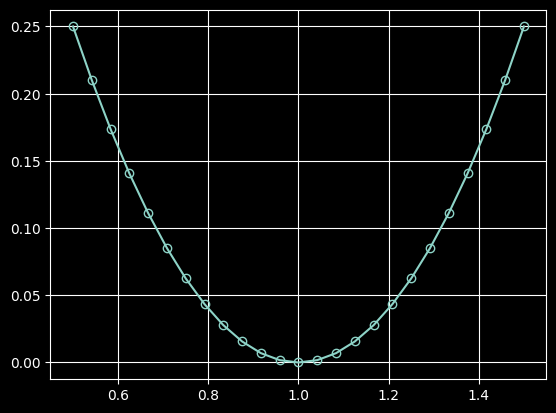

In [ ]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 25) # созданим вектор "пропорций" от 50% до 150%
yhat = decline* 1 # на примере 1 точке
loss = loss_func(yhat, 1) # посчитаем функцию потерь
plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid();  # визуализируем

Получается действительно парабола и чем дальше от исходной точки - том больше

## Градиент функции потерь

Сразу отметим, что нам потребуется не только сама фунция потерь, но и ее производная по набору оптимизируемых параметров $\{w_j\}$.   
$$\frac{\partial L_i}{\partial w_j} = 2\left(\sum_{j=0}^{m}x_{ij}w_j-y_i\right)x_{ij} = 2(\hat{y}_i - y_i)x_{ij},$$
где  $\frac{\partial L_i}{\partial w_j}$ - частная производная функции $L_i$ по параметру $w_j$  <br>   
тогда по набору всех переменных мы получим производную вида:
$$\nabla_{W}L_i  = 2(\hat{y}_i-y_i)\odot X_i,  $$
 где <ul>
    <li> $\nabla_{W}L_i$ - градиент, то есть набор частных производных функции $L_i$ по набору \{$w_j$\}.  
    <li> $\odot$ - операция поэлементного умножения (умножение Адамара)    

In [ ]:
def grad_loss(y_hat, y, X, add_bias = True):
    """Оценим градиент функции потерь
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    X: признаки
    add_bias: учитываем смещение или нет
    """
    if add_bias: # если учитываем смещение
        X_full = np.column_stack((np.ones(X.shape[0]),X)) # добавляем единички по количеству точек данных
    else:
        X_full = X # иначе ничего не делаем

    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  # градиент функции потерь как среднее от матричного умножения признаков на разницу предсказание-реальное

Проведем расчет градиента ошибки

Если "недобор" (предсказание меньше реального значения) то градиент будет отрицательный


In [ ]:
grad_loss(np.array([1]), # предсказание
          np.array([2]), # реальное значение
          np.array([2])  # признак
          )

array([-2., -4.])

Если "перебор" (предсказание меньше реального значения) то градиент будет положительный

In [ ]:
grad_loss(np.array([2]), # предсказание
          np.array([1]), # реальное значение
          np.array([2])  # признак
          )

array([2., 4.])

Если "где-то больше, где-то меньше" - то зависит от того каких отклонений больше

In [ ]:
grad_loss(np.array([2, 1.5]),# предсказание
          np.array([1, 2]),  # реальное значение
          np.array([0.5, 3])   # признак
          )

array([ 0.5, -1. ])

## Обновление весов

Опимизацию мы будем проводить методом граидентного спуска. <br>
По сути этот метод сводится к последовательному (итерационному) пересчету значений весовых параметров обратно значеням градиента ошибки (то есть в направлении, обратном направлению роста ошибки).
<br> Обозначим номер итерации как  $t$, тогда выражение для обновления весовых параметров можно записать как:

$$ W^t = W^{t-1}-\eta\nabla_{W}L(\hat{y}_i,y_i)=W^{t-1} - 2\eta (\hat{y}_i-y_i)\odot X_i^T  $$

где <ul>
<li> $\eta$ - коэффициент с которым изменяются значения весовых параметров - т.н. скорость обучения;



In [ ]:
def update_weights(grad, W, learning_rate):
    """Обновим веса
    Входные переменные:
    ===========
    grad: значение градиента
    W: веса
    learning_rate: скорость обучения
    """
    return W - learning_rate*grad # просто из старых весов вычитаем градиент помноженный на скорость обучения

Протестируем

In [ ]:
update_weights(np.array([5]), # градиент
               np.array([10]), # текущие веса
               0.5)

array([7.5])

В зависимости от знака градиента будут или увеличиваться, или уменьшаться веса

In [ ]:
update_weights(np.array([5, -5]), # градиент
               np.array([10, 10]), # текущие веса
               0.1)

array([ 9.5, 10.5])

Протестируем функции вместе на "реальных" данных

In [ ]:
weights = init_weights(x_train.shape[1]) # генерируем веса
yhat = predict( x_train[0],weights) # делаем предсказание на 1 точке
loss = loss_func(yhat, y_train[0]) # посчитаем функцию потерь

print(f'Веса {weights}')

print(f'Первая точка-признак {x_train[0]},\n Предсказание {yhat},\n Реальное значение {y_train[0]},\n Функция потерь: {loss}')

grad = grad_loss(yhat, y_train[0], x_train[0]) # делаем оценку градиента функции потерь

print(f'Градиент {grad}')

# теперь проведем обновление весовых параметров
laerning_rate = 0.1
weights = update_weights(grad, weights, laerning_rate)

print('После обновления')

yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y_train[0])

print(f'Веса {weights}')

print(f'Первая точка-признак {x_train[0]},\n Предсказание {yhat},\n Реальное значение {y_train[0]},\n Функция потерь: {loss}')

Веса [0.         0.49671415]
Первая точка-признак [0.80839735],
 Предсказание [0.4015424],
 Реальное значение 3.6824500570963057,
 Функция потерь: [10.76435503]
Градиент [-6.56181531 -5.30455409]
После обновления
Веса [0.65618153 1.02716956]
Первая точка-признак [0.80839735],
 Предсказание [1.48654268],
 Реальное значение 3.6824500570963057,
 Функция потерь: [4.82200921]


Функция потерь уменьшается - теория в целом пока работает

Но не запускать нам это всё вручную

Опять подготовим функцию

## Собирем градиентный спуск для регрессии в одну функцию

Создадим процедуру обучения как функцию `fit`.

Процедура будет повторять порцесс пересчета весов методом градиентного спуска заданое число раз (`epochs`).<br>
Функция будет требовать на вход <ul>
    <li> `X` - набор входных значений (т.н. батч ) в формате: $\textrm{число записей}\times\textrm{значения в записи}$;
    <li> `y` - набор целевых переменных (labels);   
    <li> `weights` - начальные значения весовых параметров;
    <li> `learning_rate` - скорость обучения ($\eta$);    
    <li> `epochs`   -  число эпох обучения.
        </ul>
Функция дает на выходе:<ul>
    <li> `weights` - набор обученных весовых параметров;
    <li> `cost`    - график функции потерь.
 </ul>
Также отметим, что на практике мы можем обновлять весовые параметры не для кажого отдельного значения $i$, а для целого набора таких значений, тогда более верное выражение будет выглядеть как

$$ W^t = W^{t-1}-\eta\frac{1}{n}\sum_{i=0}^{n-1}\nabla_{W}L(\hat{y}_i,y_i),  $$
где $n$ - объем выборки.        

In [ ]:
def fit(X, y, learning_rate, weights = None,  epochs=30):
    """Обучение модели.
    Входные переменные:
    ===========
    X: признаки
    y: реальные значения
    learning_rate: скорость обучения
    weights: веса
    epochs: количество эпох обучения
    """

    if weights is None: weights = init_weights(X.shape[1]) # если веса не заданы - генерируем веса случайно
    # это если хотим продолжать обучение

    cost    = np.zeros(epochs) # создадим массив из нулей

    for i in range(epochs): # цикл по количеству эпох
    # на каждом шаге
        yhat    = predict(X,weights) # делаем предсказание
        grad    = grad_loss(yhat,  y, X)  # считаем производную функции потерь
        weights = update_weights(grad, weights, learning_rate)  # обновляем веса
        cost[i] = loss_func(yhat,  y).mean() # фиксируем среднее значение функции потерь. на память. потому что можем

    return weights, cost # возвращаем итоговые веса (после epochs шагов обновлений) и график функции потерь. потому что нам интересно

Протестируем обучение

In [ ]:
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)

In [ ]:
def plot_cost(cost):
    """Отрисовка функции потерь.
    Входные переменные:
    ===========
    cost: функция потерь
    """
    fig = go.Figure()
        # рисуем с помощью библиотеки plotly
    fig.add_trace(
            go.Scatter(
            y=cost,
            mode='lines+markers',
            name='Реальные данные',

            )
        )
    fig.update_layout(
                title="Кривая обучения",
                width=1200,
                height=600,
            template = "plotly_dark"
                )

    fig.show()

In [ ]:
plot_cost(cost);

## Коэффициент детерминации

Теперь проверим как точно предсказывает наша функция, для этого мы можем воспользоваться метрикой $R^2$, метрика соотвествует относительной среднеквадратичной ошибке, она может быть расчитана как:
$$
R^2 = 1-\frac{\sum_{i=0}^{n-1}(y_i - \hat{y}_i)^2}{\sum_{i=0}^{n-1}(y_i - \mathrm{ev}(y))^2} = 1 - \frac{SS_{\rm res}}{SS_{\rm tot}},
$$
где
<ul>
    <li>$SS_{\rm res} = \sum_{i=0}^{n-1}L_i = \sum_{i=0}^{n-1}(y_i - \hat{y}_i)^2$ сумма квадратов остатков, величина, характеризующая степень того на сколько наша модель не соответствует нашим данным - то есть то, на сколько мы не можем объяснить нашей моделью наши данные;</li>
    <li>$SS_{\rm tot}$ - дисперсия данных - то есть сумма квадратов разностей значений данных и их среднего значения;</li>
    <li>$\mathrm{ev}(y) = \frac{1}{n}\sum_{i=0}^{n-1}y_i$ - среднее значение.</li>  
</ul>  

Отметим, важное обстоятельство. Для расчета градиента мы использовали функцию потерь. Однако, для оценки качества модели мы пользуемся другой функцией метрикой. Дело в том, что значения функции потерь, сколь небольшими бы они нибыли, очень сложно интерпретировать. Более того, можно ожидать, что для другого метода оптимизации значения могли быть и другими. Таким образом значения функции потерь не подходят для оценки качества модели.  Качество работы модели как правило определяется по некоторым метрикам. Такие метрики должны быть интерпретируемыми и едиными для всех сравниваемых оценщиков. В нашем случае метрика соответствует среднему квадрату ошибки в $%$. Тогда результат работы метрики мы можем интерпретировать как средняя ошибка предсказания для нашей модели. Чем ниже эта ошибки (для разных моделей), тем лучше.

In [ ]:
def r2_score(yhat, y):
    """Расчет коэффициента детерминации.
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    """
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [ ]:
predicts = predict( x_test,weights,)

r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.818294732486739, 0.8570755941810686)

Посмотрим на то, какая интерпретация может быть у предсказанных и заданных данных.

In [ ]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    """Отрисовка модели.
    Входные переменные:
    ===========
    x_train: признаки на которых тренировались
    y_train: тренировочные целевые значения
    x_test: тестовые признаки
    x: полные признаки
    y: реальные целевые значения (без шума)
    weights: веса
    """
    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x_test[:,0],
        y=predict(x_test,weights, ),
        mode='markers',
        name='Предсказание на x_test',
        marker=dict(size = 10,
                    color='Blue')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=predict(x_train,weights, ),
        mode='markers',
        name='Предсказание на x_train',
        marker=dict(size = 15,
                    color='LightSkyBlue',
                    ),

        )
    )

    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=y_train,
        mode='markers',
        name='Тренировочные данные',
        marker=dict(size = 5,
                    color='Red')
        )
    )

    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y[:,0],
        mode='lines+markers',
        name='Истинные значения',
        opacity = 0.7,
        marker=dict(size = 15,
                    color='green',),

        )
    )

    fig.update_layout(
            title='Тренировочные и тестовые данные',
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()

In [ ]:
plot_model_weights(x_train, y_train, x_test, x, y_true, weights);

Неплохо, но "еще бы чуть-чуть" дообучить

Варианты
* просто добавить эпох
* добавить эпох и уменьшить скорость обучения


### Мини-задание

Дообучите предыдущую модель, добавив на вход функции `fit` значения весов `weight` после предыдущей процедуры обучения
* сравните результаты с изменением скорости обучения и без

### Анализ весов модели

In [ ]:
weights

array([2.04548417, 1.55145866])

In [ ]:
def vis_weigths(weights):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса
    """
    numbers = np.arange(0,len(weights)) # создаем массив от 0 до количество весов-1
    tick_labels = np.array(['w'+str(num) for num in numbers]) # создаем "названия" весов


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

In [ ]:
vis_weigths(weights)

## Про батчи

На практике как правило, на каждой эпохе рассматривается не вся выборка, а только некоторая ее часть - т.н. батч (мини пакет).
Запишем функцию для генерации минибатчей заданного размера.

In [ ]:
def load_batch(X,y, batch_size = 100):
    """загрузка батча.
    Входные переменные:
    ===========
    X: признаки
    y: целевые переменные
    batch_size: размер батча
    """
    idxs = np.arange(y.size) # массив всех индексов
    np.random.shuffle(idxs) # перемешиваем индексы

    for i_batch in range(0,y.size,batch_size): # берем столько батчей, сколько "влезет" в размерность данных
        idx_batch = idxs[i_batch:i_batch+batch_size] # индексы текущего батча
        x_batch   = np.take(X, idx_batch,axis=0) # признаки в текущем батче
        y_batch   = np.take(y, idx_batch) # целевые переменные в текущем батче
        yield  x_batch, y_batch # возвращаем текущий батч
        # использование yield вместо return позволит на следущем вызове функции не запускать всё заново, а продолжить итерировать в цикле

Также запишем функцию оптимизации методом стохастического градиентного спуска.

In [ ]:
BATCH = 10

def fit_SGD(X, y, learning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    """Обучение модели с разбиением данных на батчи.
    Входные переменные:
    ===========
    X: признаки
    y: реальные значения
    learning_rate: скорость обучения
    weights: веса
    epochs: количество эпох обучения
    batch_size: размер батча
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """

    if random_state: np.random.seed(random_state)# фиксируем случайный seed

    if weights is None: weights = init_weights(X.shape[1])# если веса не заданы - генерируем веса случайно
    # это если хотим продолжать обучение


    if batch_size is None or batch_size>y.size : batch_size = y.size  # "чиним" если размер батча не задан, или он больше количества данных
    n_batches = y.size//batch_size # считаем сколько батчей "влезет" в нашу выборку

    cost    = np.zeros(epochs) # создадим массив из нулей

    for i in range(epochs): # цикл по количеству эпох
    # на каждом шаге
        loss = 0 #считаем функцию потерь в рамках отдельной эпохи
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): # перебираем данные по батчам

            yhat    = predict(x_batch, weights) # делаем предсказание в рамках текущего батча
            grad    = grad_loss(yhat,  y_batch, x_batch) # считаем производную функции потерь в рамках текущего батча
            weights = update_weights(grad, weights, learning_rate) # обновляем веса
            loss   += loss_func(yhat,  y_batch).mean()# фиксируем среднее значение функции потерь в рамках текущего батча

            if cnt>= n_batches: # неполные батчи не учитываем)
                break
        cost[i] = loss/n_batches # функция потерь как среднее от функций потерь на всех батчах в рамках эпохи

    return weights, cost #возвращаем итоговые веса (после epochs шагов обновлений) и график функции потерь.

Запустим Обучение модели с разбиением данных на батчи

In [ ]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, learning_rate=0.1, weights= weights,  batch_size = 10,  epochs=10)

predicts = predict(x_test, weights, )
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.9713449130365535, 0.9682541600832693)

Какие при этом получились веса

In [ ]:
weights

array([2.08099055, 1.84530316])

In [ ]:
vis_weigths(weights)

Эволюция функции потерь

In [ ]:
plot_cost(cost);

Визуализация модели

In [ ]:
plot_model_weights(x_train, y_train, x_test, x, y_true, weights);

Уже почти идеально, хотя мы формально использовали столько же данных для обновления

Просто обновляли чаще на меньших группах

Мораль - не делайте домашку за последний день, лучше понемногу в течении семестра

## ООП edition

Теперь давайте объеденим все наши части в один класс линейной регресии.

методы, в этом классе это функции, которые мы обсуждали с вами ранее

In [ ]:
class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.n_batches = n_batches


    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        # расчет функции потерь
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        # расчет градиента
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        # обновление весов
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        # инициализируем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        # делем предсказание модели
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        # оценка по коэффициенту детерминации
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y):
        # обучение модели с учетом разбиения на батчи
        np.random.seed(self.seed)

        if self.weights is None: # если веса не заданы - задаем
            self.weights = self.init(X.shape[1])

        if self.bias is None: # если смещение не задано - задаем
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]: # если веса заданы, но не добавлено смещение - объединяем
            self.weights = np.append(self.bias,self.weights)

        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:   # проверка на согласование размерности батча и размерности данных
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        for i in range(self.epochs): #циклы обучения, как раньше
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches

        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        # загрузка батча
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch) # тут мы всегда добавляем смещение
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        # добавление смещения
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = 'Кривая обучения'):
        # отрисовка сразу в методе
        fig = go.Figure()
            # рисуем с помощью библиотеки plotly
        fig.add_trace(
                go.Scatter(
                y=self.cost,
                mode='lines+markers',
                name='Реальные данные',

                )
            )
        fig.update_layout(
                    title=title,
                    width=1200,
                    height=600,
                template = "plotly_dark"
                    )

        fig.show()

    #---------------------------------
    def get_w_and_b(self):
        # "новый" метод - который возвращает веса модели и смещение
        return (self.weights[1:], self.bias)

# Полиномиальная Зависимость

Приминяем описанные в начале блокнота функции для генерации полиномиальной зависимости вида

`y = -2*x^3+2x^2+1*x-1`, где `х` изменяется в диапазоне от `0` до `1.25`, в `х` - `250` точек, "мощность" шума `0.05`

для этого запускаем функцию `dataset` с нужными параметрами

*   `a = [1,2,-2]` (на первое число умножится `х`, на второе число умножится `х^2` и т.д.)
*  ` b = -1 `(это число добавится к `a*х`)
*   `f = None` (чтобы не было никаких других зависимостей)
*   `N = 250` (число точек)
*   `x_max =1` (максимальное значение `х`)
*   `noise_power = 0.05` (мощность шума)
*   `seed = 42` (фиксированный сид случайных чисел)
                       

а потом визуализируем данные с помощью функции `vis_data`

In [ ]:
y, y_true, x = dataset(a = [1,2,-2], b = -1,
                       f = None,  N = 250,
                       x_max =1.25,
                       noise_power = 0.05,
                       seed = 42)
vis_data_plotly(y, y_true,x, 'Полиномиальная зависимость')

Не забываем про разбиение данных на тренировочную и валидационную

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3, )

Используем написанный ранее класс для этих данных

In [ ]:
# Создаем экземпляр класса
regr_poly_lin = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
# Применяем метод fit
regr_poly_lin.fit(x_train, y_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_poly_lin.score(x_train, y_train):.2f}')
regr_poly_lin.plot_cost()

Коэффициент детерминации на тренировочных данных = 0.51


In [ ]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    """Отрисовка модели которая реализована через классы.
    Входные переменные:
    ===========
    x_train: признаки на которых тренировались
    y_train: тренировочные целевые значения
    x_test: тестовые признаки
    x: полные признаки
    y: реальные целевые значения (без шума)
    model: обученная модель
    """

    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x_test[:,0],
        y=model.predict(x_test, ),
        mode='markers',
        name='Предсказание на x_test',
        marker=dict(size = 5,
                    color='Blue')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=model.predict(x_train, ),
        mode='markers',
        name='Предсказание на x_train',
        marker=dict(size = 10,
                    color='LightSkyBlue',
                    ),

        )
    )

    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=y_train,
        mode='markers',
        name='Тренировочные данные',
        marker=dict(size = 5,
                    color='Red')
        )
    )

    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y[:,0],
        mode='lines+markers',
        name='Истинные значения',
        opacity = 0.7,
        marker=dict(size = 10,
                    color='green',),

        )
    )

    fig.update_layout(
            title='Предсказание модели',
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()

Пытаемся визуализировать

In [ ]:
plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin);

Модель старалась, но у неё ничего не получилось, а жаль

## Полиномиальные данные

Теперь попробуем реализовать полиномиальную регрессию.
Как известно члены полиномов различных целых степеней можно считать независимыми функциями. Поэтому
регрессия может быть представлена как многопеременная линейная регрессия.

Для реализации давайте запишем функцию `to_polynom` создающую полином из входных данных `x`. Выход функуции будет массив, имеющий число столбцов, равное степени искомого полинома.

In [ ]:
def to_polynom(x, order = 1, add_bias = False):
    """Генерация полиномиальных признаков .
    Входные переменные:
    ===========
    x: признаки
    order: порядок полинома
    add_bias: добавляем ли константу (так вроде делает и scikit-learn)
    """
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))# складываем в выходную переменную все степени от 0/1 до order
    return out.reshape(-1, x.size).T

Сделаем, например полиномы до 3 степени

In [ ]:
x_ = to_polynom(x, order = 3)
x_train, x_test, y_train, y_test = train_test_split(x_, y,  test_size=0.3, )

Создадим новую модель

In [ ]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

Обучим её методом `.fit`

In [ ]:
regr_poly.fit(x_train, y_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_poly.score(x_train, y_train):.2f}')
regr_poly.plot_cost()

Коэффициент детерминации на тренировочных данных = 0.97


Рисуем результат

In [ ]:
plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly);

Вроде выглядит неплохо

Смотрим на веса

В цифрах

In [ ]:
w, b = regr_poly.get_w_and_b()
print(w,b)

[ 1.89484269  0.29602795 -1.12349434] -1.093299641493549


И в картинке

In [ ]:
vis_weigths(np.hstack([b,w]))

# Посмотрим, как это все будет выглядеть на гармонических данных

Приминяем описанные в начале блокнота функции для генерации полиноминальной зависимости вида

`y = cos(2*pi*x+pi)`, где `х` изменяется в диапазоне от `0` до `pi/3`, в `х` - `50` точек, "мощность" шума `0.1`

для этого запускаем функцию `dataset` с нужными параметрами

*   `a = 2*np.pi` (на это число умножится `х`)
*  ` b = np.pi `(это число добавится к `a*х`)
*   `f = np.cos` (эта функция применится `a*х+b`)
*   `N = 50` (число точек)
*   `x_max =np.pi/3` (максимальное значение `х`)
*   `noise_power = 0.1` (мощность шума)
*   `seed = 42` (фиксированный сид случайных чисел)
                       

а потом визуализируем данные с помощью функции `vis_data`

In [ ]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,
                       N = 50, x_max =np.pi/3,
                       noise_power = 0.1, seed = 42)
vis_data_plotly(y, y_true,x, 'Гармоническая зависимость')

не забываем разбивать на тренировочную и валидационную выборку

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3, )
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(35, 1) (35,) (15, 1) (15,)


Запоминаем, эту процедуру мы будем использовать очень много раз (с небольшими вариациями)

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

In [ ]:
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

Коэффициент детерминации на тренировочных данных = 0.00


Визуализируем модель

Опять "просто" не получается

In [ ]:
plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm);

## Полиномиальная регрессия


Создадим наш набор данных

10 степень полиномов, для надежности

In [ ]:
order  = 10

x_train_ = to_polynom(x_train, order=order) # для тренировочных
x_test_  = to_polynom(x_test,  order=order) # для тестовых


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
31,0.190407,0.036255,0.006903,0.001314,2.502711e-04,4.765328e-05,9.073502e-06,1.727655e-06,3.289571e-07,6.263562e-08
32,0.640731,0.410536,0.263043,0.168540,1.079887e-01,6.919167e-02,4.433324e-02,2.840567e-02,1.820039e-02,1.166155e-02
33,0.036012,0.001297,0.000047,0.000002,6.056345e-08,2.180985e-09,7.854071e-11,2.828375e-12,1.018542e-13,3.667931e-15
34,0.326423,0.106552,0.034781,0.011353,3.705990e-03,1.209721e-03,3.948808e-04,1.288982e-04,4.207534e-05,1.373436e-05


Опять идем по стандартному маршрушу

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

In [ ]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Коэффициент детерминации на тестовых данных = {regr_harm_poly.score(x_test_, y_test):.2f}, \n Коэффициент детерминации на тренировочных данных = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()



Коэффициент детерминации на тестовых данных = 0.41, 
 Коэффициент детерминации на тренировочных данных = 0.68


In [ ]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 2.10780575  0.42714302 -0.17405947 -0.2311899  -0.85745282 -0.80629031
 -0.13060886 -0.26815298 -0.53928071 -0.10548005] -0.6665371994488514


In [ ]:
vis_weigths(np.hstack([b,w]))

In [ ]:
np.sum(np.abs(w))

5.647463879933974

"Ну почти" получилось нужное

In [ ]:
plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly);

Как видно из таблицы наши данные имеют слегка  разный масштаб. Чтобы было, если бы мы взяли более высокие порядки? Для компенсации этого эффекта часто для данных применяют перемасштабирование - нормализацию. Этот процесс можно описать следующим выражением:
$$ x' =\frac{x - \min(x)}{\max(x) - \min(x)}$$

Давайте попробуем посмотреть к чему это приводит

In [ ]:
class MinMaxScaler:
    # Класс нормализации. Класс чтобы "запомнить" параметры которые вычитали / делили
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        # обучаем - ищем максимальное и минимальное значение
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        # трансформируем по формуле
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        # питоновское "объединяем" два метода в один
        return self.fit(X).transform(X)

$$ x' =\frac{x - mean(x)}{std(x)}$$

In [ ]:
class StandardScaler:
    # Класс стандартизации. Класс чтобы "запомнить" параметры которые вычитали / делили
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        # обучаем - ищем среднее и стандартное отклонение
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        # трансформируем по формуле
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        # питоновское "объединяем" два метода в один
        return self.fit(X).transform(X)

Допустим воспользуемся стандартизацией

In [ ]:
scaler = StandardScaler() # создаем экземпляр класса
x_train_scaled = scaler.fit_transform(x_train_) # обучаем на тренировочных и сразу трансформируем
x_test_scaled = scaler.transform(x_test_) # обучаем трансформируем тестовые данные

Выглядит более однородно

In [ ]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9
11,1.290826,1.314799,1.202790,1.042037,0.873383,0.713301,0.567758,0.438375,0.324924,0.226372
12,-0.818138,-0.806942,-0.701026,-0.607631,-0.541376,-0.496097,-0.464670,-0.442123,-0.425319,-0.412306
13,0.271678,-0.030467,-0.232614,-0.342675,-0.395187,-0.416225,-0.421213,-0.418529,-0.412527,-0.405378
14,0.860650,0.673987,0.441925,0.236037,0.072468,-0.051594,-0.143407,-0.210200,-0.258052,-0.291783


И вновь

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

In [ ]:

regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)

print(f'Коэффициент детерминации на тестовых данных = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, \n Коэффициент детерминации на тренировочных данных = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')

regr_harm_poly_scale.plot_cost()



Коэффициент детерминации на тестовых данных = 0.97, 
 Коэффициент детерминации на тренировочных данных = 0.95


In [ ]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.73051734 -0.26424088 -0.76261794 -0.58089313 -0.93862771 -0.63683296
  0.2562212   0.30131014  0.18156999  0.74026176] -0.06024795911914328


In [ ]:
vis_weigths(np.hstack([b,w]))

In [ ]:
np.sum(np.abs(w))

6.393093053065999

Посмотрим на результат.

In [ ]:
fig = go.Figure()
    # рисуем с помощью библиотеки plotly
fig.add_trace(
    go.Scatter(
    x=x_test[:,0],
    y=regr_harm_poly_scale.predict(x_test_scaled),
    mode='markers',
    name='Предсказание на x_test',
    marker=dict(size = 5,
                color='Blue')
    )
)
fig.add_trace(
    go.Scatter(
    x=x_train[:,0],
    y=regr_harm_poly_scale.predict(x_train_scaled),
    mode='markers',
    name='Предсказание на x_train',
    marker=dict(size = 10,
                color='LightSkyBlue',
                ),

    )
)

fig.add_trace(
    go.Scatter(
    x=x_train[:,0],
    y=y_train,
    mode='markers',
    name='Тренировочные данные',
    marker=dict(size = 5,
                color='Red')
    )
)

fig.add_trace(
    go.Scatter(
    x=x[:,0],
    y=y_true[:,0],
    mode='lines+markers',
    name='Истинные значения',
    opacity = 0.7,
    marker=dict(size = 10,
                color='green',),

    )
)

# возьмем дополнительную точку "вне" тренировочного диапазона
x_new = np.array([1.05, 1.07, 1.08, 1.09, 1.1])
fig.add_trace(
    go.Scatter(
    x=x_new,
    y=regr_harm_poly_scale.predict(scaler.transform(to_polynom(x_new, order=order))),
    mode='markers',
    name='Новые данные',
    marker=dict(size = 5,
                color='Purple')
    )
)

fig.update_layout(
        title='Предсказание модели',
        width=1200,
        height=600,
    template = "plotly_dark"
        )

fig.show()


Мини вывод - стандартизация данных может улучшить результаты

# Метод Наименьших Квадратов

Для более детального сравнения давайте также посмотрим на аналитическое решение проблемы - методом наименьших квадратов

In [ ]:
order = 10
x_train_ls = to_polynom(x_train, order=order, add_bias=True)
x_test_ls  = to_polynom(x_test,  order=order, add_bias=True)
# в библиотеке numpy есть реализация МНК в рамках модуля линейной алгебры linalg.lstsq LeaSTSQuares
weights  = np.linalg.lstsq(x_train_ls, y_train, rcond=None)[0] #с учетом смещения

In [ ]:
weights

array([-8.69971720e-01, -1.05350795e+00, -9.49283445e+01,  1.99165390e+03,
       -1.41545730e+04,  5.41571702e+04, -1.24039972e+05,  1.74367054e+05,
       -1.47329953e+05,  6.86886777e+04, -1.35841838e+04])

Видим что веса какие-то неадекватные

In [ ]:
vis_weigths(weights)

In [ ]:
np.sum(np.abs(weights))

598410.0894238534

Предсказание полиномиальной модели

In [ ]:
def polyval(x,weights):
    return np.sum([np.power(x,i)*wi for i, wi in enumerate(weights) ],axis = 0) # с учетом смещения

In [ ]:
print(f"Ошибка на тестовых данных = {r2_score(y_test, polyval(x_test,weights).squeeze()):.2f}, \n Ошибка на тренировочных данных =  {r2_score(y_train, polyval(x_train,weights).squeeze()):.2f}")


Ошибка на тестовых данных = 0.98, 
 Ошибка на тренировочных данных =  0.99


Посмотрим на результат.

In [ ]:
fig = go.Figure()
    # рисуем с помощью библиотеки plotly
fig.add_trace(
    go.Scatter(
    x=x_test[:,0],
    y=polyval(x_test, weights)[:,0],
    mode='markers',
    name='Предсказание на x_test',
    marker=dict(size = 5,
                color='Blue')
    )
)
fig.add_trace(
    go.Scatter(
    x=x_train[:,0],
    y=polyval(x_train, weights)[:,0],
    mode='markers',
    name='Предсказание на x_train',
    marker=dict(size = 10,
                color='LightSkyBlue',
                ),

    )
)

fig.add_trace(
    go.Scatter(
    x=x_train[:,0],
    y=y_train,
    mode='markers',
    name='Тренировочные данные',
    marker=dict(size = 5,
                color='Red')
    )
)

fig.add_trace(
    go.Scatter(
    x=x[:,0],
    y=y_true[:,0],
    mode='lines+markers',
    name='Истинные значения',
    opacity = 0.7,
    marker=dict(size = 10,
                color='green',),

    )
)

# возьмем дополнительную точку "вне" тренировочного диапазона
x_new = np.array([1.05, 1.07, 1.08, 1.09, 1.1])
fig.add_trace(
    go.Scatter(
    x=x_new,
    y=polyval(x_new, weights),
    mode='markers',
    name='Новые данные',
    marker=dict(size = 5,
                color='Purple')
    )
)

fig.update_layout(
        title='Предсказание модели',
        width=1200,
        height=600,
    template = "plotly_dark"
        )


Аналитическое решение методом наименьших квадратов дало результаты лучше чем численное на тренировочных данных

Однако, градиентный спуск позволяет поднять точность на тестовых данных.

# Регуляризация линейной регрессии

## Регуляризация Тихонова

Часто бывает так, что обычный градиентный спуск приводит к переобучению модели. Переобучение это ситуация, когда точность на обучающих данных значительно выше, чем на тестовых.

В таких случаях также можно сказать, что данные плохо обусловлены - то есть любые небольшие изменения по отношению к тренировочной выборке приведут к большим изменениям в ответе модели. В целом это будет означать, что модель дает очень большой разброс результатов.

Такой разброс может быть снижен при помощи различных техник регуляризации. Смысл использования таких техник сводится к тому, что при обучении модели к выражению обновления весовых параметров добавляется дополнительное условие.

Например, можно добавить условие ограничение суммы квадратов весовых параметров. Такое предположение называется регрессией Тихонова или гребневой регрессией (а также L2 регуляризацией).

Технически такая регуляризация соответствует предположению, что распределение результатов работы модели имеет вид нормального распределения. Такое предположение часто допустимо и оправдано.<br>
Регрессия Тихонова может быть записана в следующей форме:

$$ \begin{cases}
L(\hat{y}_i,y_i)\to \min \\
\| W \|_2^2< \mathrm{const}
\end{cases}
\to L(\hat{y}_i,y_i) + \frac{\lambda}{2}\sum_{j=1}^{p} W_j^2\to \min,
$$
где  
<ul>
     <li> $ \| W \|_2^2 = \sum_{j=1}^{p} W_j^2$ - норма Фробениуса для вектора или матрицы;
     <li> $ \lambda $   - регуляризационный множитель;  
     <li> $p$ - размер вектора весовых параметров;
</ul>
Закон изменения весовых параметров для данной модели можно зписать как:
$$ W^t = W^{t-1}-\eta\left(\frac{1}{N}\sum_{i=0}^{N-1}\nabla_{W}L(\hat{y}_i,y_i) + \lambda\sum_{j=1}^{p} W_j\right). $$
Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss`     и `update`. Также отметим, что смещение не регуляризуется !

In [ ]:
class RidgeRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)


И снова
* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

In [ ]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train_, y_train)

print(f'Ошибка на тестовых данных = {regr_l2.score(x_test_, y_test):.2f}, \n Ошибка на тренировочных данных = {regr_l2.score(x_train_, y_train):.2f}')
regr_l2.plot_cost()

Ошибка на тестовых данных = 0.97, 
 Ошибка на тренировочных данных = 0.95


In [ ]:
w, b = regr_l2.get_w_and_b()
print(w,b)

[ 5.4568901  -0.31919438 -2.5264715  -2.55100074 -2.46637139 -1.50659708
  0.0698673   0.74870062  1.18956599  2.23422861] -1.2891362141228053


In [ ]:
vis_weigths(np.hstack([b,w]))

In [ ]:
np.sum(np.abs(w))

19.0688876936735

Посмотрим на результат.

In [ ]:
plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l2);

Вроде как регуляризация помагает как и стандартизация

## Регуляризация L1
В ряде случаев, когда разброс данных оказывается очень большим, регуляризации L2 может оказаться бесполезной или даже вредной. Дело в том, что в функции потерь мы учитываем веса в квадрате и большие колебания весовых параметров приведут к в квадрате большим колебаниям в значениях функции потерь. Часто эта ситуация является недопустимой.

В таких случаях следует выбирать более устойчивые (робастные методы). Робастные методы могут быть менее точными, однако более стабильными. Одним из наиболее распространённых робастных методов является L1 регуляризация. В этом случае выражение для функции потерь может быть записано следующим образом:
$$ \begin{cases}
L(\hat{y}_i,y_i)\to \min \\
\| W \|_1^1 <\mathrm{const}
\end{cases}
\to L(\hat{y}_i,y_i) + \frac{\lambda}{2}\sum_{j=1}^{p} W_j\to \min,
$$
где  
<ul>
     <li> $ \| W \|_1^1 = \sum_{j=1}^{p} |W_j|$ - норма L1 для вектора или матрицы;
     <li> $ \lambda $   - регуляризационный множитель;  
     <li> $p$ - размер вектора весовых параметров;
</ul>
Закон изменения весовых параметров для данной модели можно зписать как:
$$ W^t = W^{t-1}-\eta\left(\frac{1}{N}\sum_{i=0}^{N-1}\nabla_{W}L(\hat{y}_i,y_i) + \lambda*sign(W^{t-1})\right). $$
Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss`     и `update`.

In [ ]:
class LassoRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Вы не поверите, но

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

In [ ]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1.fit(x_train_, y_train)

print(f'Ошибка на тестовых данных = {regr_l1.score(x_test_, y_test):.2f}, \n Ошибка на тренировочных данных = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

Ошибка на тестовых данных = 0.79, 
 Ошибка на тренировочных данных = 0.86


In [ ]:
w, b = regr_l1.get_w_and_b()
print(w,b)

[ 3.88674506 -0.02553245 -1.31063996 -1.38550494 -1.6403498  -1.1334317
 -0.00955853  0.20494101  0.33425247  1.02204273] -0.9995536602834406


In [ ]:
vis_weigths(np.hstack([b,w]))

In [ ]:
np.sum(np.abs(w))

10.952998642294355

Посмотрим на результат.

In [ ]:
plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1);

Важное замечание

Регуляризация - не панацея. Не всегда помогает

## Эластичная регуляризация
Отметим, что во многих случаях неизвестно какая модель регуляризации окажется лучше, поэтому целесообразно использовать их обе вместе. Такая модель регуляризации называется эластической регуляризацией. Попробуем ее реализовать

In [ ]:
class ElasticRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

И в последний раз в этом блокноте

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

In [ ]:
regr_l1l2 = ElasticRegression(learning_rate=0.1,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.0001,l2_penalty = 0.001 )
regr_l1l2.fit(x_train_, y_train)

print(f'Ошибка на тестовых данных = {regr_l1l2.score(x_test_, y_test):.2f}, \n Ошибка на тренировочных данных = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()

Ошибка на тестовых данных = 0.80, 
 Ошибка на тренировочных данных = 0.87


In [ ]:
w, b = regr_l1l2.get_w_and_b()
print(w,b)

[ 3.92008426  0.03235775 -1.3787937  -1.42837648 -1.69711616 -1.18349794
 -0.04187663  0.24588499  0.36211507  1.12587409] -1.0090541478031454


In [ ]:
vis_weigths(np.hstack([b,w]))

In [ ]:
np.sum(np.abs(w))

11.415977077611501

Посмотрим на результат.

In [ ]:
plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2);